In [1]:
import re
import pandas as pd
import xarray as xr
from numpy import ones
from numpy.linalg import cholesky
from pandas_plink import read_plink1_bin
from limix.qc import quantile_gaussianize

In [2]:
import cellregmap 
cellregmap 

<module 'cellregmap' from '/hps/nobackup2/stegle/users/acuomo/git_repos/CellRegMap/cellregmap/__init__.py'>

In [6]:
from cellregmap import run_association, run_association_fast

In [7]:
input_files_dir = "/hps/nobackup2/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/input_files/"

In [8]:
## sample mapping file
## this file will map cells to donors 
## it will also only include donors we have single-cell data for (a subset of all of HipSci donors)
sample_mapping_file = input_files_dir+"sample_mapping_file.csv"
sample_mapping = pd.read_csv(sample_mapping_file, dtype={"genotype_individual_id": str, "phenotype_sample_id": str})

In [9]:
## genotype_individual_id are donor IDs, as found in the genotype matrix (G) and GRM covariance (K)
## phenotype_sample_id are cell IDs, as found in the scRNA-seq phenotype vector (y) and cell context covariance (C)
sample_mapping.head()

,genotype_individual_id,phenotype_sample_id
0,HPSI0114i-joxm_1,21843_1#10
1,HPSI0314i-fafq_1,21843_1#100
2,HPSI0314i-fafq_1,21843_1#101
3,HPSI1013i-wuye_2,21843_1#102
4,HPSI0114i-joxm_1,21843_1#103


In [10]:
## extract unique individuals
donors = sample_mapping["genotype_individual_id"].unique()
donors.sort()
print("Number of unique donors: {}".format(len(donors)))

Number of unique donors: 126


In [11]:
############################################
################ Kinship matrix ############
############################################

In [14]:
## read in GRM (genotype relationship matrix; kinship matrix)
kinship_folder="/hps/nobackup2/stegle/users/acuomo/hipsci_genotype_files/"
kinship_file=kinship_folder+"hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.kinship"
K = pd.read_csv(kinship_file, sep="\t", index_col=0)
assert all(K.columns == K.index) #symmetric matrix, donors x donors

In [15]:
K = xr.DataArray(K.values, dims=["sample_0", "sample_1"], coords={"sample_0": K.columns, "sample_1": K.index})
K = K.sortby("sample_0").sortby("sample_1")
donors = sorted(set(list(K.sample_0.values)).intersection(donors))
print("Number of donors after kinship intersection: {}".format(len(donors)))

Number of donors after kinship intersection: 125


In [16]:
## subset to relevant donors
K = K.sel(sample_0=donors, sample_1=donors)
assert all(K.sample_0 == donors)
assert all(K.sample_1 == donors)

In [17]:
## and decompose such as K = hK @ hK.T (using Cholesky decomposition)
hK = cholesky(K.values)
hK = xr.DataArray(hK, dims=["sample", "col"], coords={"sample": K.sample_0.values})
assert all(hK.sample.values == K.sample_0.values)

In [18]:
del K
print("Sample mapping number of rows BEFORE intersection: {}".format(sample_mapping.shape[0]))
## subsample sample mapping file to donors in the kinship matrix
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]
print("Sample mapping number of rows AFTER intersection: {}".format(sample_mapping.shape[0]))

Sample mapping number of rows BEFORE intersection: 34256
Sample mapping number of rows AFTER intersection: 33964


In [19]:
############################################
##### expand from donors to cells ##########

In [20]:
## use sel from xarray to expand hK (using the sample mapping file)
hK_expanded = hK.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(hK_expanded.sample.values == sample_mapping["genotype_individual_id"].values)

In [21]:
######################################
############### Genotypes ############
######################################

In [22]:
## read in genotype file (plink format)
plink_folder = "/hps/nobackup2/stegle/users/acuomo/hipsci_genotype_files/"
plink_file = plink_folder+"hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.bed"
G = read_plink1_bin(plink_file)

Mapping files: 100%|██████████| 3/3 [05:57<00:00, 119.25s/it]


In [23]:
#############################
###### SNP selection

In [24]:
# filter file (columns: snp_id, gene)
endo_eqtl_file = input_files_dir+"endodiff_eqtl_allconditions_FDR10pct.csv"
endo_eqtl = pd.read_csv(endo_eqtl_file, index_col = False)
endo_eqtl["chrom"] = [int(i[:i.find("_")]) for i in endo_eqtl["snp_id"]]
endo_eqtl.head(2)

,snp_id,feature,stage,chrom
0,5_149826526_C_T,ENSG00000164587_RPS14,ips,5
1,11_57283988_C_T,ENSG00000134809_TIMM10,ips,11


In [25]:
chrom = 22
# and consider eGenes on that chromosome
genes = endo_eqtl[endo_eqtl['chrom']==int(chrom)]['feature'].unique()

In [26]:
#########################################################
# cis window around a specific gene (discovery)

In [27]:
def cis_snp_selection(feature_id, annotation_df, G, window_size):
    feature = annotation_df.query("feature_id==\"{}\"".format(feature_id)).squeeze()
    chrom = str(feature['chromosome'])
    start = feature['start']
    end = feature['end']
    # make robust to features self-specified back-to-front
    lowest = min([start,end])
    highest = max([start,end])
    # for cis, we sequentially add snps that fall within each region
    G = G.where((G.chrom == str(chrom)) & (G.pos > (lowest-window_size)) & (G.pos < (highest+window_size)), drop=True)
    return G

In [28]:
# (1) gene name (feature_id)
gene_name = genes[0]
trait_name = re.sub("_.*","",gene_name)
trait_name

'ENSG00000100058'

In [30]:
# (2) annotation linking gene to genomic position
annotation_file = "/hps/nobackup2/stegle/users/acuomo/Ensembl_75_Limix_Annotation_FC_Gene.txt"
anno_df = pd.read_csv(annotation_file, sep="\t", index_col=0)
anno_df.head(2)

,chromosome,start,end
feature_id,,,
ENSG00000271782,1,50902700,50902978
ENSG00000232753,1,103817769,103828355


In [31]:
# (3) window size (cis)
w = 100000

In [32]:
G_sel = cis_snp_selection(trait_name, anno_df, G, w)

In [33]:
G_sel.shape

(1610, 1078)

In [34]:
############################################
##### expand from donors to cells ##########

In [35]:
# expand out genotypes from cells to donors (and select relevant donors in the same step)
G_expanded = G_sel.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(hK_expanded.sample.values == G_expanded.sample.values)

/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


In [36]:
G_expanded.shape

(33964, 1078)

In [37]:
######################################
############## Phenotypes ############
######################################

In [38]:
# Phenotype (single-cell expression)
phenotype_file = input_files_dir+"phenotype.csv.pkl"
phenotype = pd.read_pickle(phenotype_file)
print("Phenotype shape BEFORE selection: {}".format(phenotype.shape))
phenotype = xr.DataArray(phenotype.values, dims=["trait", "cell"], coords={"trait": phenotype.index.values, "cell": phenotype.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)
print("Phenotype shape AFTER selection: {}".format(phenotype.shape))
assert all(phenotype.cell.values == sample_mapping["phenotype_sample_id"].values)

Phenotype shape BEFORE selection: (11231, 34256)
Phenotype shape AFTER selection: (11231, 33964)


In [39]:
# select gene
y = phenotype.sel(trait=gene_name)
# quantile normalise
y = quantile_gaussianize(y)

In [40]:
######################################
########## Cell contexts #############
######################################

In [41]:
# cells by MOFA factors (20)
C_file = "/hps/nobackup2/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/mofa_logcounts_model_factors.csv"
C = pd.read_csv(C_file, index_col = 0)
C = xr.DataArray(C.values, dims=["cell", "pc"], coords={"cell": C.index.values, "pc": C.columns.values})
C = C.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(C.cell.values == sample_mapping["phenotype_sample_id"].values)

In [42]:
# quantile normalise cell contexts
C = quantile_gaussianize(C)

In [43]:
######################################
############ Covariates ##############
######################################

In [44]:
n_cells = phenotype.shape[1]
W = ones((n_cells, 1))

In [45]:
y = y.values.reshape(y.shape[0],1)
y.shape

(33964, 1)

In [46]:
W

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [47]:
C.values[:,0:10].shape
C.values[:,0:10]

array([[-0.22698835,  0.82917178,  0.23411244, ...,  0.07390445,
         0.30870685, -0.66988754],
       [ 0.11928532,  2.94980516,  0.8196344 , ..., -0.3224365 ,
         1.85295159, -0.70238707],
       [ 0.05970302,  1.86963924,  0.02166209, ...,  0.1331965 ,
         1.00717123,  0.75346536],
       ...,
       [-0.39533548,  0.72850657, -1.20369879, ..., -0.20673893,
         0.31816383, -0.3551869 ],
       [-0.26984302,  1.04975257, -0.57387367, ...,  0.13543057,
         0.58636113, -0.12188718],
       [-0.38132928,  1.2401305 , -0.68501989, ...,  0.33271513,
         0.47799852,  0.28748933]])

In [48]:
GG = G_expanded.values

In [49]:
GG.shape

(33964, 1078)

In [51]:
import time

In [124]:
start_time = time.time()
pvals0 = run_association_fast(y=y, W=W, E=C.values[:,0:10], G=GG[:,0:100], hK=hK_expanded)[0]
print("--- %s seconds ---" % (time.time() - start_time))

--- 17.29796552658081 seconds ---


In [125]:
pv0 = pd.DataFrame({"chrom":G_expanded[:,0:100].chrom.values,
               "pv":pvals0,
               "variant":G_expanded[:,0:100].snp.values})
pv0.head()

,chrom,pv,variant
0,22,1.000000,22_25744472_C_T
1,22,1.000000,22_25744915_T_C
2,22,1.000000,22_25745441_G_A
3,22,0.125525,22_25746593_C_T
4,22,0.397030,22_25746647_C_T


In [70]:
from cellregmap import CellRegMap
from numpy_sugar.linalg import economic_svd
from numpy_sugar import ddot

In [116]:
start_time = time.time()
crm = CellRegMap(y=y, W=W, E=C.values[:,0:10], hK=hK_expanded)
pvals = crm.scan_association_fast(GG[:,0:100])[0]
print("--- %s seconds ---" % (time.time() - start_time))

--- 14.578105449676514 seconds ---


In [117]:
pv1 = pd.DataFrame({"chrom":G_expanded[:,0:100].chrom.values,
               "pv":pvals,
               "variant":G_expanded[:,0:100].snp.values})
pv1.head()

,chrom,pv,variant
0,22,0.999996,22_25744472_C_T
1,22,0.999996,22_25744915_T_C
2,22,0.999996,22_25745441_G_A
3,22,0.098412,22_25746593_C_T
4,22,0.629932,22_25746647_C_T


In [106]:
import numpy as np
import matplotlib.pyplot as plt

In [107]:
from scipy.stats import pearsonr

In [126]:
pearsonr(-np.log10(pv1['pv']),-np.log10(pv2['pv']))

(0.9036399759160336, 7.225326750282023e-38)

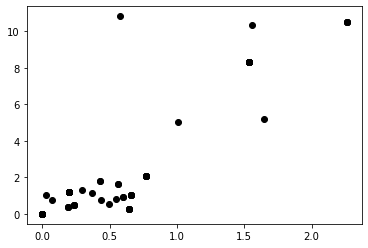

In [127]:
plt.plot(-np.log10(pv1['pv']),-np.log10(pv2['pv']),'o', color='black')

In [128]:
pearsonr(-np.log10(pv1['pv']),-np.log10(pv0['pv']))

(0.92451215452483, 7.695877166124892e-43)

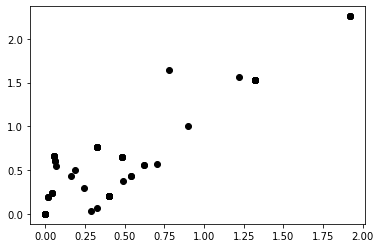

In [129]:
plt.plot(-np.log10(pv0['pv']),-np.log10(pv1['pv']),'o', color='black')

In [130]:
pearsonr(-np.log10(pv['pv']),-np.log10(pv0['pv']))

(0.9999690452451699, 5.023585594482506e-208)

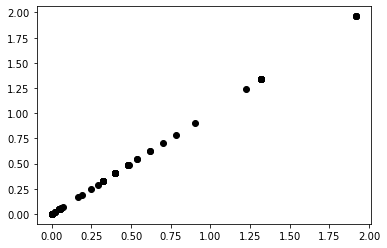

In [131]:
plt.plot(-np.log10(pv0['pv']),-np.log10(pv['pv']),'o', color='black')

In [132]:
pearsonr(-np.log10(pv0['pv']),-np.log10(pv2['pv']))

(0.934858683888416, 7.221580521419355e-46)

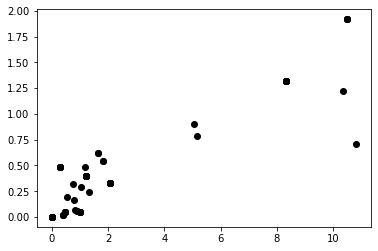

In [133]:
plt.plot(-np.log10(pv2['pv']),-np.log10(pv0['pv']),'o', color='black')

In [118]:
[U, S, _] = economic_svd(C)
del _
us = U * S
Ls = [ddot(us[:,i], hK_expanded) for i in range(us.shape[1])]
del us

In [119]:
start_time = time.time()
crm = CellRegMap(y=y, W=W, E=C.values[:,0:10], Ls=Ls)
print("--- %s seconds ---" % (time.time() - start_time))

--- 68.1155161857605 seconds ---


In [120]:
start_time = time.time()
pvals = crm.scan_association_fast(GG[:,0:100])[0]
print("--- %s seconds ---" % (time.time() - start_time))

--- 248.54602003097534 seconds ---


In [121]:
pv2 = pd.DataFrame({"chrom":G_expanded[:,0:100].chrom.values,
               "pv":pvals,
               "variant":G_expanded[:,0:100].snp.values})
pv2.head()

,chrom,pv,variant
0,22,1.000000,22_25744472_C_T
1,22,1.000000,22_25744915_T_C
2,22,1.000000,22_25745441_G_A
3,22,0.000009,22_25746593_C_T
4,22,0.060168,22_25746647_C_T


In [122]:
start_time = time.time()
pvals = run_association(y, W, C.values[:,0:10], G=GG[:,0:100], hK=hK_expanded)[0]
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 100/100 [02:19<00:00,  1.40s/it]

--- 156.75114011764526 seconds ---


In [123]:
pv = pd.DataFrame({"chrom":G_expanded[:,0:100].chrom.values,
               "pv":pvals,
               "variant":G_expanded[:,0:100].snp.values})
pv.head()

,chrom,pv,variant
0,22,1.000000,22_25744472_C_T
1,22,1.000000,22_25744915_T_C
2,22,1.000000,22_25745441_G_A
3,22,0.123862,22_25746593_C_T
4,22,0.396499,22_25746647_C_T
